# Age regression from brain MRI

**Develop an accurate predictor of brain age given 652 healthy subjects (brain MRI data and age).**

In [1]:
! pip install SimpleITK 


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Setting data directory

In [1]:
# data directory
data_dir = 'data/brain_age/'

### Metadata

In [2]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


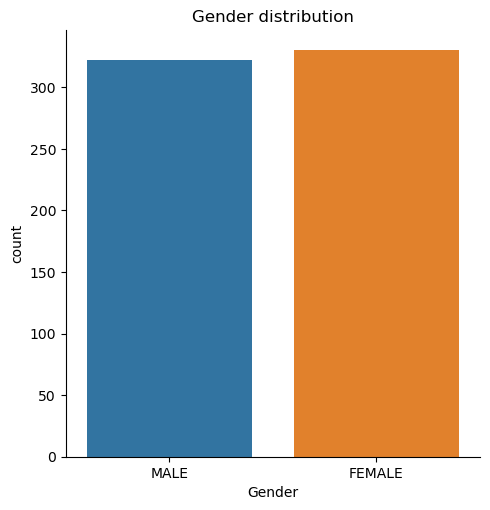

c:\Users\ethan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


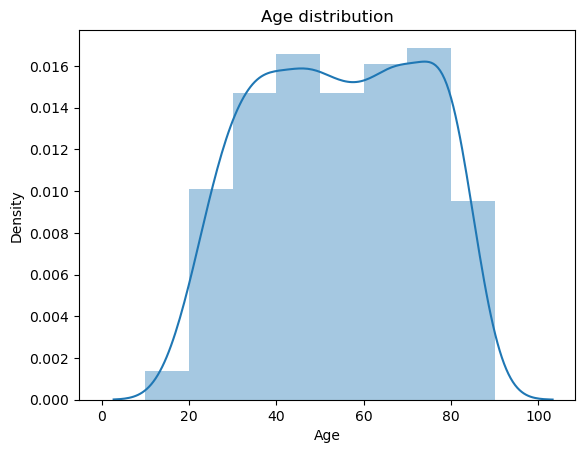

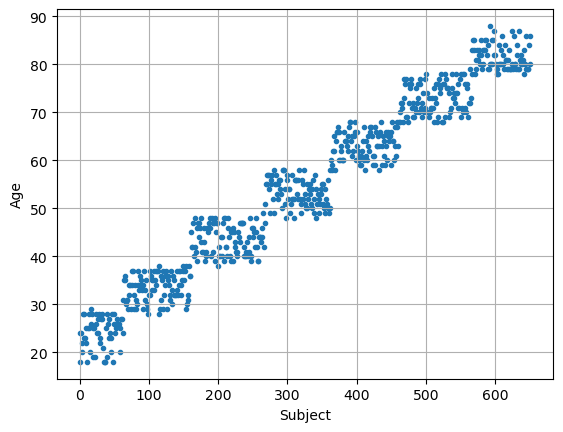

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=np.arange(0, 100, 10))
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Image viewing utils

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Imaging data of subject CC110033 with age 24

MR Image


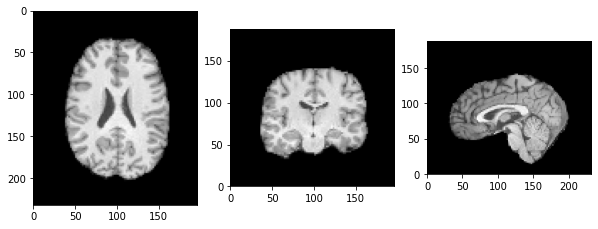

Brain mask


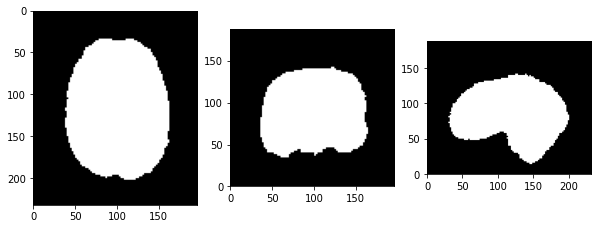

In [7]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume.

(Are all volume features equally useful? Is it even better to combine some of them and create new features? Do I need regularisation?)

### Brain tissue segmentation

U-Net 3D model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF.

#### Imports

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [6]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### GPU check

In [7]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: NVIDIA GeForce GTX 1650


#### Config and hyper-parameters

In [7]:
rnd_seed = 42

img_size = [128, 128, 128]
img_spacing = [1, 1, 1]

num_epochs = 30
learning_rate = 0.005
batch_size = 1
val_interval = 1

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading of training and validation data

In [18]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

In [13]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


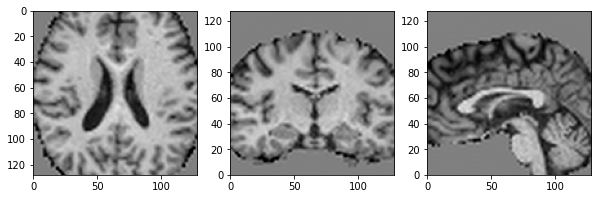

Segmentation


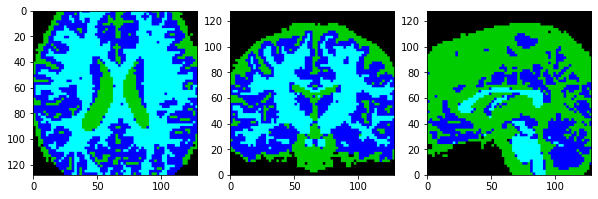

Mask


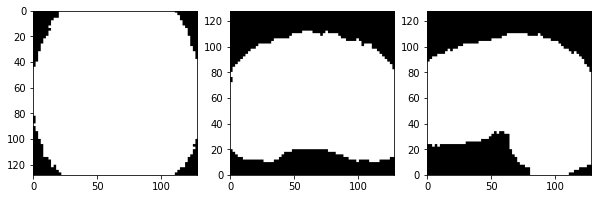

In [14]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### Model

**U-Net 3d**

In [13]:
########################################
# BUILD A BETTER MODEL HERE
########################################
def get_block(in_channels, out_channels, kernel_size = 3, padding = 1):
    return nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, padding = padding), nn.BatchNorm3d(out_channels), nn.LeakyReLU(0.2))

class UNet3D(nn.Module):
 
    def __init__(self, num_classes, d = 32):
        super(UNet3D, self).__init__()
        self.down_layer_1 = nn.Sequential(get_block(1, d), get_block(d, d * 2))
        self.down_layer_2 = nn.Sequential(nn.MaxPool3d(2, 2), get_block(d * 2, d * 2), get_block(d * 2, d * 4))
        self.down_layer_3 = nn.Sequential(nn.MaxPool3d(2, 2), get_block(d * 4, d * 4), get_block(d * 4, d * 8))
        self.down_up_layer = nn.Sequential(nn.MaxPool3d(2, 2), get_block(d * 8, d * 8), get_block(d * 8, d * 16), nn.ConvTranspose3d(d * 16, d * 16, 2, 2))
        self.up_layer_1 = nn.Sequential(get_block(d * 8 + d * 16, d * 8), get_block(d * 8, d * 8), nn.ConvTranspose3d(d * 8, d * 8, 2, 2))
        self.up_layer_2 = nn.Sequential(get_block(d * 4 + d * 8, d * 4), get_block(d * 4, d * 4), nn.ConvTranspose3d(d * 4, d * 4, 2, 2))
        self.up_layer_3 = nn.Sequential(get_block(d * 2 + d * 4, d * 2), get_block(d * 2, d * 2))
        self.out_conv = nn.Conv3d(d * 2, num_classes, 1, padding = 0)

    def forward(self, x):
        down_1_out = self.down_layer_1(x)
        down_2_out = self.down_layer_2(down_1_out)
        down_3_out = self.down_layer_3(down_2_out)
        down_up_out = self.down_up_layer(down_3_out)
        up_1_out = self.up_layer_1(torch.cat([down_3_out, down_up_out], dim = -4))
        up_2_out = self.up_layer_2(torch.cat([down_2_out, up_1_out], dim = -4))
        up_3_out = self.up_layer_3(torch.cat([down_1_out, up_2_out], dim = -4))
        out = self.out_conv(up_3_out)
        return out

#### TRAINING

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.466526
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.465347


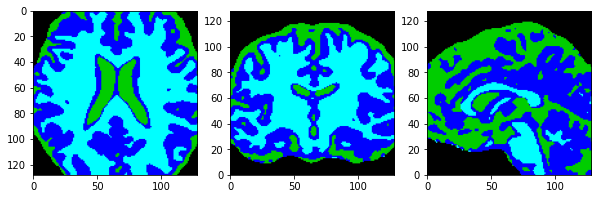

--------------------------------------------------
Epoch time:  46.6878924369812
+ TRAINING 	Epoch: 2 	Loss: 0.325174
--------------------------------------------------
+ VALIDATE 	Epoch: 2 	Loss: 0.334329


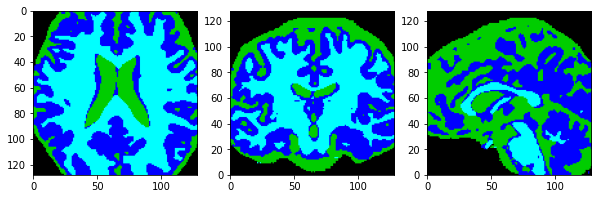

--------------------------------------------------
Epoch time:  47.67196536064148
+ TRAINING 	Epoch: 3 	Loss: 0.375640
--------------------------------------------------
+ VALIDATE 	Epoch: 3 	Loss: 0.301502


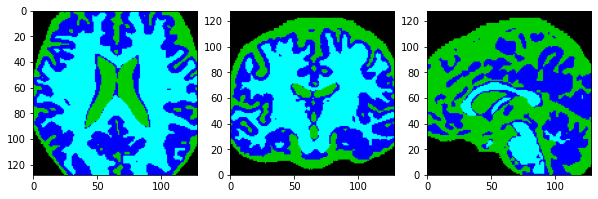

--------------------------------------------------
Epoch time:  47.97479248046875
+ TRAINING 	Epoch: 4 	Loss: 0.271667
--------------------------------------------------
+ VALIDATE 	Epoch: 4 	Loss: 0.280265


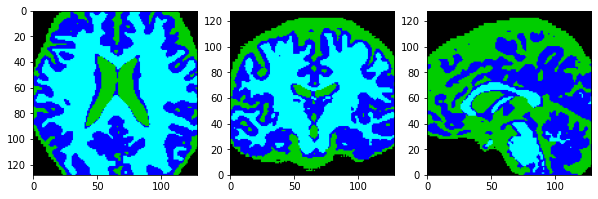

--------------------------------------------------
Epoch time:  48.21330499649048
+ TRAINING 	Epoch: 5 	Loss: 0.319342
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.252278


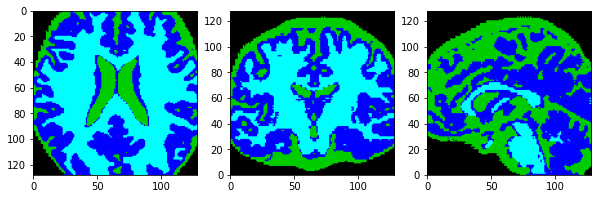

--------------------------------------------------
Epoch time:  47.87079119682312
+ TRAINING 	Epoch: 6 	Loss: 0.313820
--------------------------------------------------
+ VALIDATE 	Epoch: 6 	Loss: 0.231487


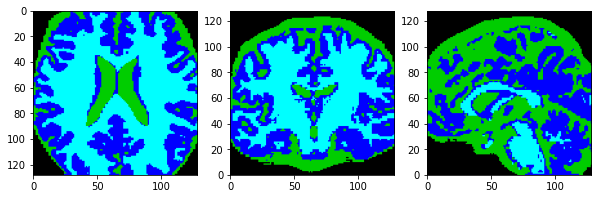

--------------------------------------------------
Epoch time:  48.32534170150757
+ TRAINING 	Epoch: 7 	Loss: 0.290911
--------------------------------------------------
+ VALIDATE 	Epoch: 7 	Loss: 0.222982


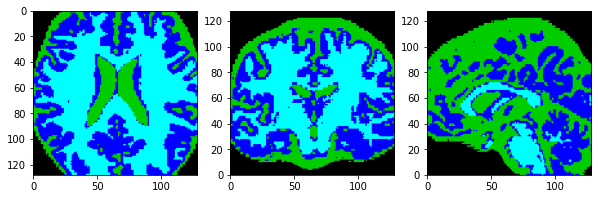

--------------------------------------------------
Epoch time:  52.791048526763916
+ TRAINING 	Epoch: 8 	Loss: 0.276217
--------------------------------------------------
+ VALIDATE 	Epoch: 8 	Loss: 0.244748


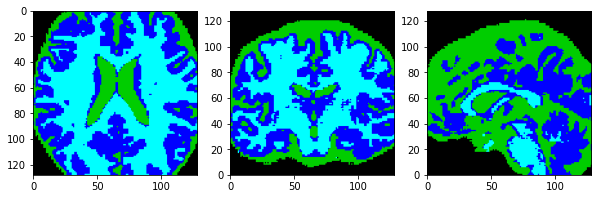

--------------------------------------------------
Epoch time:  53.219815254211426
+ TRAINING 	Epoch: 9 	Loss: 0.200178
--------------------------------------------------
+ VALIDATE 	Epoch: 9 	Loss: 0.195849


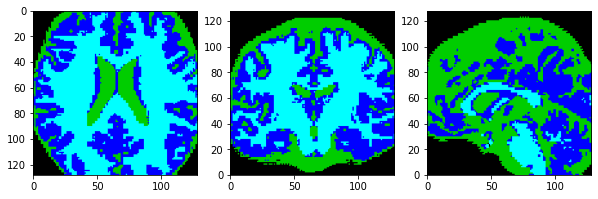

--------------------------------------------------
Epoch time:  54.01392197608948
+ TRAINING 	Epoch: 10 	Loss: 0.200751
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.194972


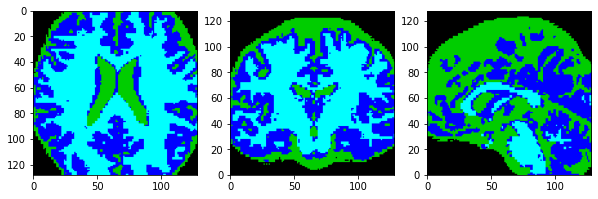

--------------------------------------------------
Epoch time:  53.701740980148315
+ TRAINING 	Epoch: 11 	Loss: 0.225432
--------------------------------------------------
+ VALIDATE 	Epoch: 11 	Loss: 0.211944


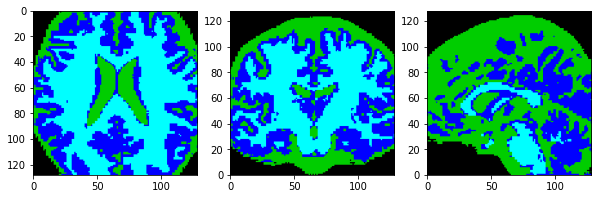

--------------------------------------------------
Epoch time:  53.7758355140686
+ TRAINING 	Epoch: 12 	Loss: 0.190723
--------------------------------------------------
+ VALIDATE 	Epoch: 12 	Loss: 0.194967


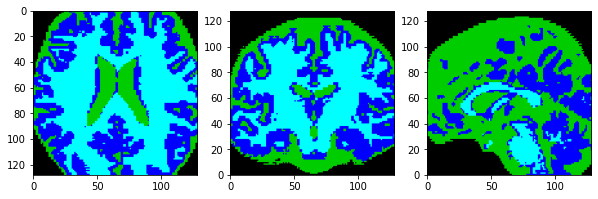

--------------------------------------------------
Epoch time:  53.659847021102905
+ TRAINING 	Epoch: 13 	Loss: 0.165045
--------------------------------------------------
+ VALIDATE 	Epoch: 13 	Loss: 0.204245


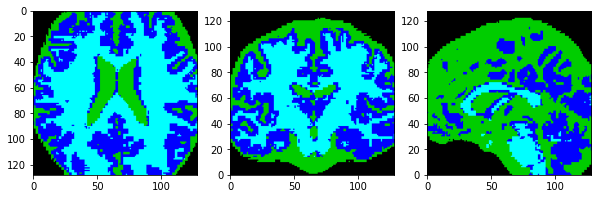

--------------------------------------------------
Epoch time:  53.636826515197754
+ TRAINING 	Epoch: 14 	Loss: 0.307213
--------------------------------------------------
+ VALIDATE 	Epoch: 14 	Loss: 0.212497


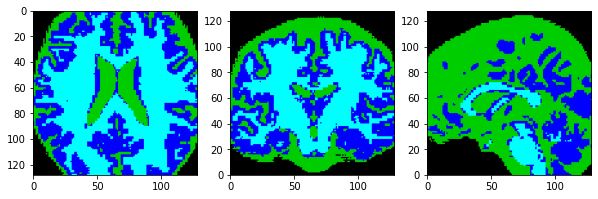

--------------------------------------------------
Epoch time:  53.69758701324463
+ TRAINING 	Epoch: 15 	Loss: 0.168961
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.177099


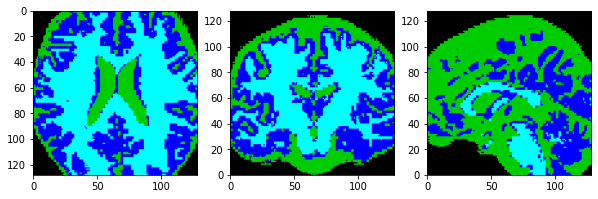

--------------------------------------------------
Epoch time:  53.432170152664185
+ TRAINING 	Epoch: 16 	Loss: 0.158995
--------------------------------------------------
+ VALIDATE 	Epoch: 16 	Loss: 0.168892


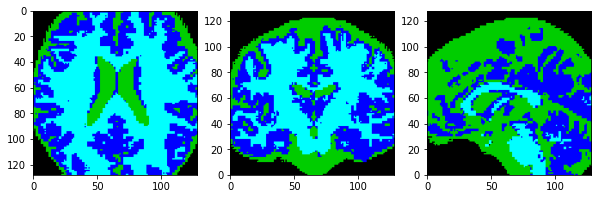

--------------------------------------------------
Epoch time:  52.986727237701416
+ TRAINING 	Epoch: 17 	Loss: 0.185548
--------------------------------------------------
+ VALIDATE 	Epoch: 17 	Loss: 0.186729


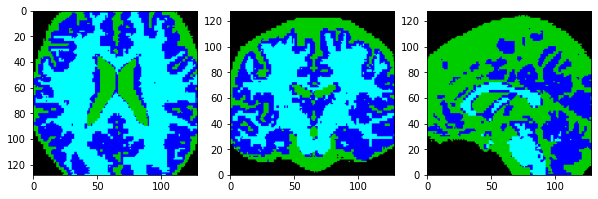

--------------------------------------------------
Epoch time:  53.37700390815735
+ TRAINING 	Epoch: 18 	Loss: 0.166313
--------------------------------------------------
+ VALIDATE 	Epoch: 18 	Loss: 0.174170


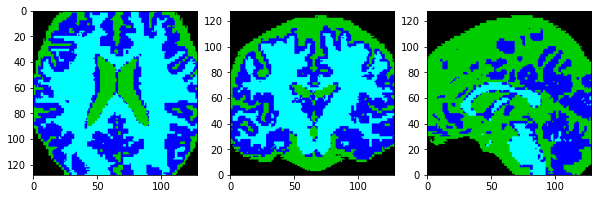

--------------------------------------------------
Epoch time:  53.59969472885132
+ TRAINING 	Epoch: 19 	Loss: 0.190214
--------------------------------------------------
+ VALIDATE 	Epoch: 19 	Loss: 0.176582


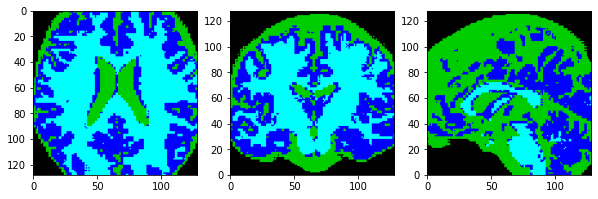

--------------------------------------------------
Epoch time:  52.71040678024292
+ TRAINING 	Epoch: 20 	Loss: 0.261436
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.197570


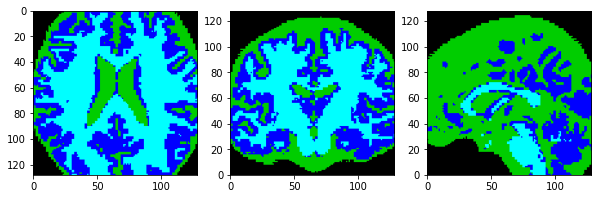

--------------------------------------------------
Epoch time:  55.32386589050293
+ TRAINING 	Epoch: 21 	Loss: 0.137914
--------------------------------------------------
+ VALIDATE 	Epoch: 21 	Loss: 0.154226


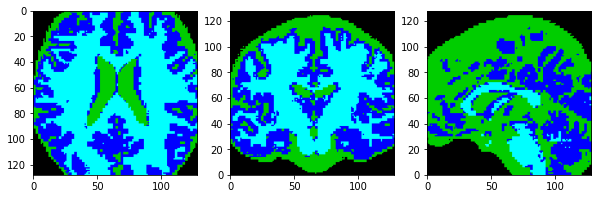

--------------------------------------------------
Epoch time:  52.513452768325806
+ TRAINING 	Epoch: 22 	Loss: 0.137265
--------------------------------------------------
+ VALIDATE 	Epoch: 22 	Loss: 0.152368


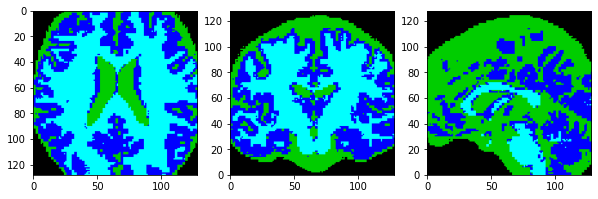

--------------------------------------------------
Epoch time:  50.05772805213928
+ TRAINING 	Epoch: 23 	Loss: 0.152692
--------------------------------------------------
+ VALIDATE 	Epoch: 23 	Loss: 0.151442


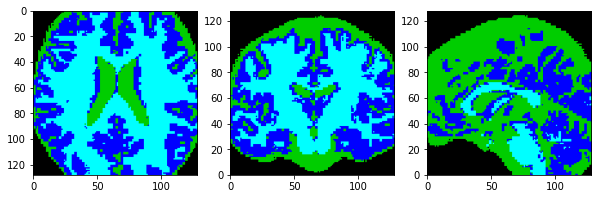

--------------------------------------------------
Epoch time:  51.05183410644531
+ TRAINING 	Epoch: 24 	Loss: 0.139866
--------------------------------------------------
+ VALIDATE 	Epoch: 24 	Loss: 0.151372


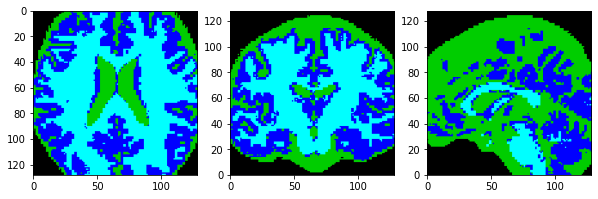

--------------------------------------------------
Epoch time:  50.362393379211426
+ TRAINING 	Epoch: 25 	Loss: 0.305759
--------------------------------------------------
+ VALIDATE 	Epoch: 25 	Loss: 0.151331


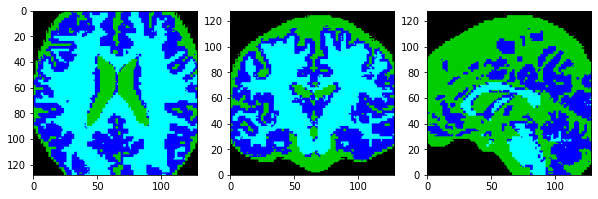

--------------------------------------------------
Epoch time:  49.93708419799805
+ TRAINING 	Epoch: 26 	Loss: 0.149691
--------------------------------------------------
+ VALIDATE 	Epoch: 26 	Loss: 0.149945


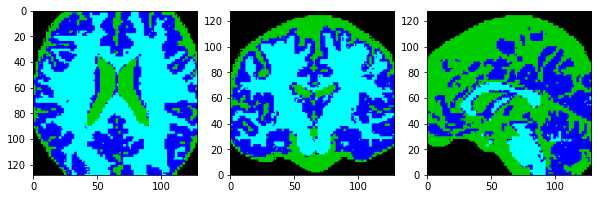

--------------------------------------------------
Epoch time:  49.324729919433594
+ TRAINING 	Epoch: 27 	Loss: 0.138777
--------------------------------------------------
+ VALIDATE 	Epoch: 27 	Loss: 0.150165


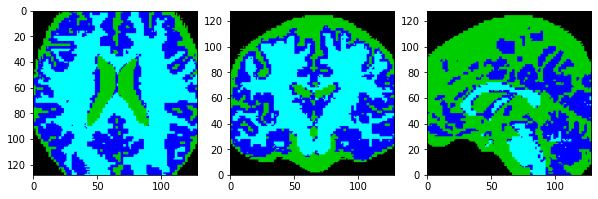

--------------------------------------------------
Epoch time:  50.78139090538025
+ TRAINING 	Epoch: 28 	Loss: 0.172573
--------------------------------------------------
+ VALIDATE 	Epoch: 28 	Loss: 0.151549


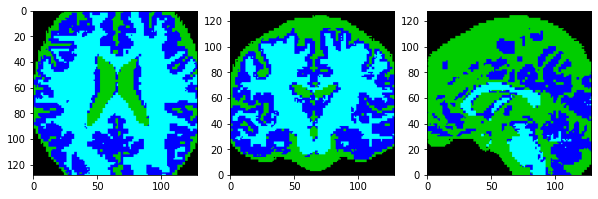

--------------------------------------------------
Epoch time:  49.94837927818298
+ TRAINING 	Epoch: 29 	Loss: 0.152885
--------------------------------------------------
+ VALIDATE 	Epoch: 29 	Loss: 0.152230


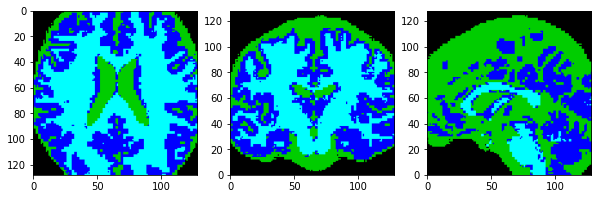

--------------------------------------------------
Epoch time:  49.78635239601135
+ TRAINING 	Epoch: 30 	Loss: 0.122845
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.151866


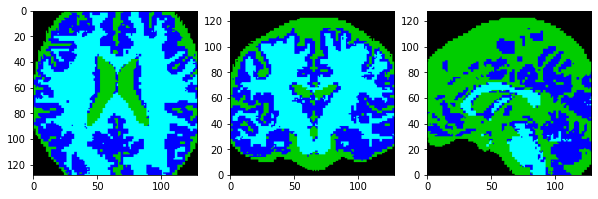

--------------------------------------------------
Epoch time:  50.167258977890015

Finished TRAINING.


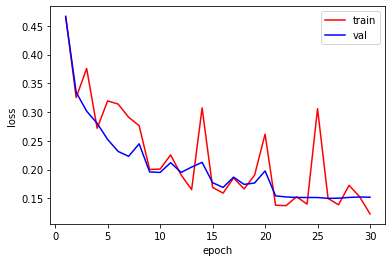

In [19]:
import time
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

try:
    del model
except Exception as e:
    print(e)
    
torch.manual_seed(rnd_seed) #fix random seed
torch.cuda.empty_cache()


model = UNet3D(num_classes=num_classes, d = 4).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):
    st_time = time.time()
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')
    
    scheduler.step()
    print("Epoch time: ", time.time() - st_time)

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading of testing data

In [9]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████████████████████████████████████████████████████████████| 500/500 [06:54<00:00,  1.21it/s]


Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


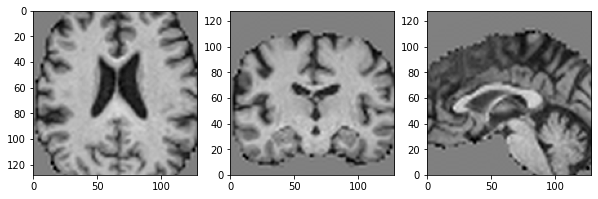

Segmentation


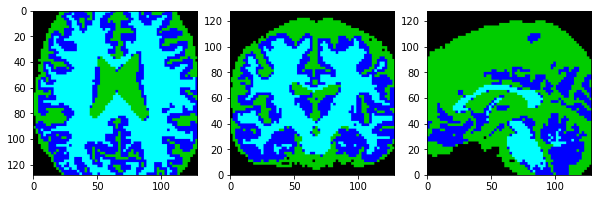

Mask


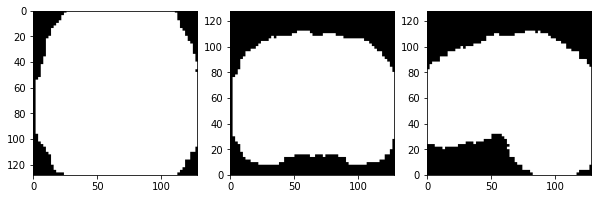

In [11]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

START TESTING...
+ TESTING 	Loss: 0.183446
Accuracy: 0.926576 	Averaged Dice Score: 0.954542
Dice score for each class:  0.987440 0.896785 0.965139 0.968802


Reference segmentation


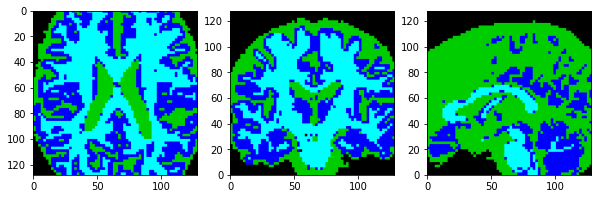

Predicted segmentation


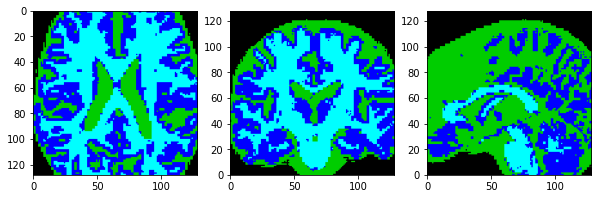


Finished TESTING.


In [15]:
def compute_tp_tn_fp_fn(prd, seg, num_classes):
    prd, seg = prd.flatten(), seg.flatten()
    res = np.zeros((num_classes, 4))
    for i in range(num_classes):
        res[i, 0] += torch.sum(torch.logical_and(prd == i, seg == i)).item()
        res[i, 1] += torch.sum(torch.logical_and(prd != i, seg != i)).item()
        res[i, 1] += torch.sum(torch.logical_and(prd == i, seg != i)).item()
        res[i, 2] += torch.sum(torch.logical_and(prd != i, seg == i)).item()
    return res

def compute_dice_acc(tp_tn_fp_fn, num_classes, average = "micro"):
    acc = np.sum(tp_tn_fp_fn, axis = 0)[0] / np.sum(tp_tn_fp_fn, axis = 1)[0]
    dice_score_classes = tp_tn_fp_fn[..., 0] / (tp_tn_fp_fn[..., 0] + (tp_tn_fp_fn[..., 2] + tp_tn_fp_fn[..., 3]) / 2)
    if average == "micro":
        dice_score = np.mean(dice_score_classes)
    elif average == "macro":
        macro = np.sum(tp_tn_fp_fn, axis = 0)
        dice_score = macro[0] / (macro[0] + (macro[2] + macro[3]) / 2)
    else:
        raise NotImplementedError()
    return acc, dice_score, dice_score_classes

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet3D(num_classes=num_classes, d = 4)
model_dir = os.path.join(out_dir, 'model')
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
tp_tn_fp_fn = np.zeros((num_classes, 4))
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
        tp_tn_fp_fn += compute_tp_tn_fp_fn(prd, seg, num_classes)
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

acc, dice_score, dice_score_classes = compute_dice_acc(tp_tn_fp_fn, num_classes)
print("Accuracy: {:.6f} \tAveraged Dice Score: {:.6f}".format(acc, dice_score))
print("Dice score for each class: ", " ".join(["{:.6f}".format(this_f1) for this_f1 in dice_score_classes.tolist()]))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### Feature calculation

In [16]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import matplotlib.pyplot as plt

seg_dir = './output/pred/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        image_array = sitk.GetArrayFromImage(seg)
        counts = np.unique(image_array, return_counts=True)
        vols[:, idx] = counts[1][1:]

Calculating Features: 100%|██████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.69it/s]


Plot features versus age.

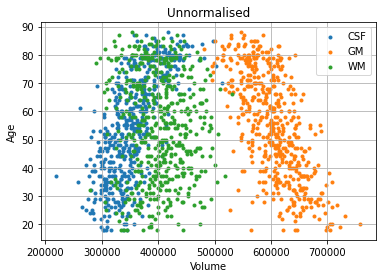

In [17]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [18]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))
vols_normalised = vols / np.sum(vols, axis=0)

Plot normalised features versus age.

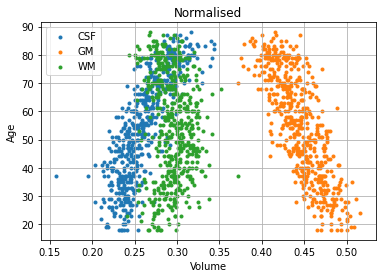

In [19]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [20]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,)

print(X.shape)
print(y.shape)

(500, 3)
(500,)


### Age regression and cross-validation

In [21]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Create regressors
regressors = [
    SVR(kernel="rbf", C=2),
    DecisionTreeRegressor(max_depth=2),
    GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 500), 
    RANSACRegressor()
]

# Predict
predictions = []
for reg in regressors:
    predictions.append(cross_val_predict(reg, X, y, cv=StratifiedKFold(2, shuffle = True)))

D:\Python38\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
D:\Python38\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
D:\Python38\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
D:\Python38\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Error calculation and plotting

SVR:
MAE: 8.1591078935686
R2: 0.697075084590657


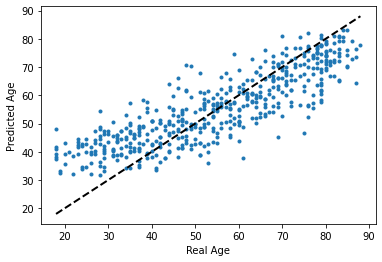

DecisionTreeRegressor:
MAE: 8.729950671688638
R2: 0.6389661298963578


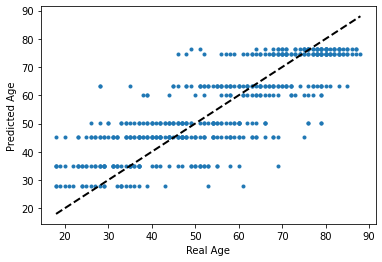

GradientBoostingRegressor:
MAE: 7.69277370847194
R2: 0.7180194906594353


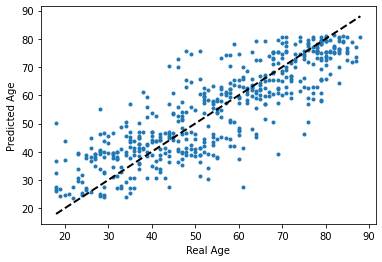

RANSACRegressor:
MAE: 8.18175
R2: 0.6911357759615915


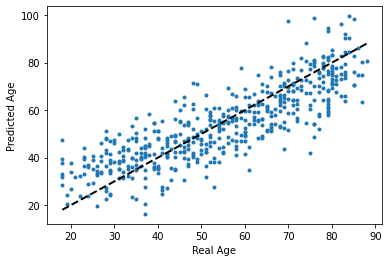

In [22]:
for reg, prediction in zip(regressors, predictions):
    print(f'{type(reg).__name__}:')
    print('MAE: {0}'.format(mean_absolute_error(y, prediction)))
    print('R2: {0}'.format(r2_score(y, prediction)))


    fig, ax = plt.subplots()
    ax.scatter(y, prediction, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

### Final test on hold-out data

#### Loading of testing data

In [23]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


#### Run final testing

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]




Reference segmentation


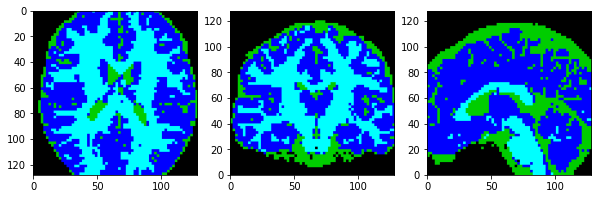

Predicted segmentation


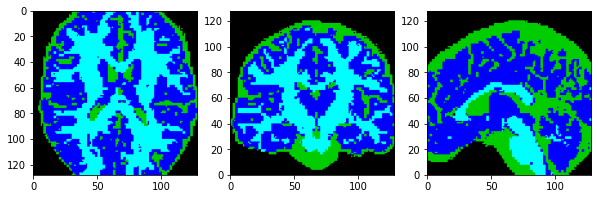

In [24]:
model_dir = os.path.join(out_dir, 'model')
pred_dir = os.path.join(out_dir, 'pred_test')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet3D(num_classes=num_classes, d = 4).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()

idx_test = 0
    
with torch.no_grad():
    for data_sample in tqdm(iter(dataloader_test)):
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

Calculating Features: 100%|██████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.74it/s]


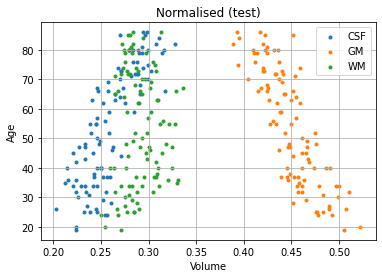

In [25]:
seg_dir = './output/pred_test/'

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols_test = np.zeros((3,len(files_reg_seg_test)))
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    seg_filename = files_reg_seg_test[idx]
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        image_array = sitk.GetArrayFromImage(seg)
        counts = np.unique(image_array, return_counts=True)
        vols_test[:, idx] = counts[1][1:]
vols_normalised_test = vols_test / np.sum(vols_test, axis=0)

plt.scatter(vols_normalised_test[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised_test[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised_test[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Normalised (test)')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

SVR:
MAE: 7.844211207674409
R2: 0.7570732991642835


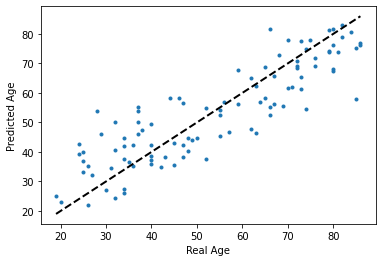

DecisionTreeRegressor:
MAE: 7.975077896795602
R2: 0.7403283113157098


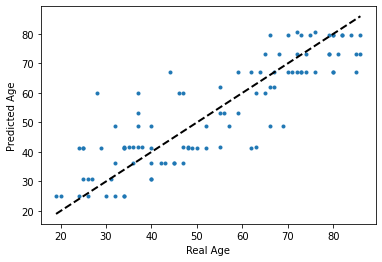

GradientBoostingRegressor:
MAE: 7.960000536421651
R2: 0.7462956084857133


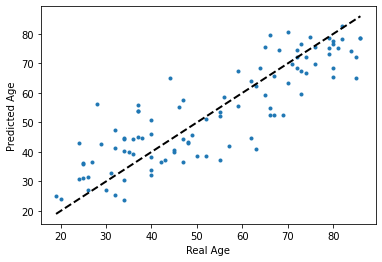

RANSACRegressor:
MAE: 8.65
R2: 0.7229963779297264


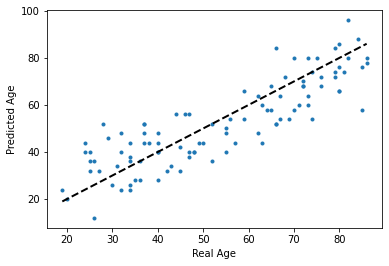

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regressors = [
    SVR(kernel="rbf", C=8, epsilon = 0.01),
    DecisionTreeRegressor(max_depth=4),
    GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100), 
    RANSACRegressor()
]

X_test = vols_normalised_test.T
y_test = meta_data_reg_test['age'].values.reshape(-1,)

predictions_test = []
for reg in regressors:
    # Fit on train data from A3
    reg.fit(X, y)
    # Predict on test data from A4
    predictions_test.append(reg.predict(X_test))

for reg, prediction in zip(regressors, predictions_test):
    print(f'{type(reg).__name__}:')
    print('MAE: {0}'.format(mean_absolute_error(y_test, prediction)))
    print('R2: {0}'.format(r2_score(y_test, prediction)))

    fig, ax = plt.subplots()
    ax.scatter(y_test, prediction, marker='.')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

## Age prediction using regression CNNs

Full end-to-end CNN implemetation for age regression using **ResNet 3d**

In [1]:
num_epochs = 50
lr = 1e-3
batch_size = 4
img_size = [128, 128, 128]
img_spacing = [1, 1, 1]
res_d = 8
patience = 5

In [2]:
import os
import pandas as pd
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
from copy import deepcopy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)

class ImageRegressionDataset(Dataset):
    """Dataset for image regression."""
    def __init__(self, files_n_ages, img_spacing, img_size):
        self.samples = []
        for img_path, msk_path, age in tqdm(files_n_ages, desc='Loading Data'):
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            self.samples.append({"img": img, "age": age})
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        age = torch.from_numpy(np.ones(1) * sample["age"])
        return {'img': image, 'age': age}

data_dir = 'data/brain_age/'
cnn_datasets = {}
for phase, meta_name in [("train", "regression"), ("val", "segmentation")]:
    meta_data = pd.read_csv(data_dir + f'meta/meta_data_{meta_name}_train.csv')
    ids, ages = list(meta_data['subject_id']), list(meta_data["age"])
    files_n_ages = []
    for f, age in zip(ids, ages):
        img_path = data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz'
        msk_path = data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz'
        files_n_ages.append((img_path, msk_path, float(age)))
    cnn_datasets[phase] = ImageRegressionDataset(files_n_ages, img_spacing, img_size)

Loading Data: 100%|████████████████████████████████████████████████████████████████████| 47/47 [00:21<00:00,  2.19it/s]


In [3]:
def get_block(in_channels, out_channels, kernel_size, stride, padding = None, activation = True):
    if padding is None:
        if kernel_size == 1:
            padding = 0
        elif kernel_size == 3:
            padding = 1
        elif kernel_size == 7:
            padding = 3
    conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    if activation:
        return nn.Sequential(conv, nn.BatchNorm3d(out_channels), nn.LeakyReLU(0.2))
    else:
        return nn.Sequential(conv, nn.BatchNorm3d(out_channels))

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.b1 = get_block(in_channels, out_channels, 3, stride)
        self.b2 = get_block(out_channels, out_channels, 3, 1, activation = False)
        self.downsample = downsample
    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        out = self.b1(x)
        out = self.b2(out)
        out += residual
        out = F.leaky_relu(out, 0.2)
        return out

class BottleneckBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(BottleneckBlock, self).__init__()
        self.b1 = get_block(in_channels, out_channels, 1, 1)
        self.b2 = get_block(out_channels, out_channels, 3, stride)
        self.b3 = get_block(out_channels, out_channels * self.expansion, 1, 1, activation = False)
        self.downsample = downsample
    def forward(self, x):
        residual = x if self.downsample is None else self.downsample(x)
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out += residual
        out = F.leaky_relu(out, 0.2)
        return out

class ResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_channels, num_classes):
        super(ResNet3D, self).__init__()
        #self.init = nn.Sequential(get_block(1, num_channels[0], 7, 1), nn.MaxPool3d(3, 2, 1))
        self.init1 = get_block(1, num_channels[0], 7, 1)
        self.init2 = nn.MaxPool3d(3, 2, 1)
        in_channels = num_channels[0]
        module_list = []
        for i, (t_num_blocks, out_channels) in enumerate(zip(num_blocks, num_channels)):
            this_layer = self._make_layer(block, t_num_blocks, in_channels, out_channels, 1 if i == 0 else 2)
            in_channels = block.expansion * out_channels
            module_list.append(this_layer)
        self.resmodules = nn.Sequential(*module_list)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(in_channels, num_classes)
    def forward(self, x):
        out = self.init1(x)
        out = self.init2(out)
        out = self.resmodules(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    def _make_layer(self, block, num_blocks, in_channels, out_channels, stride):
        if stride != 1 or in_channels != out_channels * block.expansion:
            downsample = get_block(in_channels, out_channels * block.expansion, 1, stride, activation = False)
        else:
            downsample = None
        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks - 1):
            layers.append(block(out_channels * block.expansion, out_channels))
        return nn.Sequential(*layers)

def init_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [5]:
try:
    del model
    torch.cuda.empty_cache()
except Exception as e:
    print(e)
    
cnn_dataloaders = {phase : DataLoader(dataset, batch_size = batch_size, shuffle = phase == "train") for phase, dataset in cnn_datasets.items()}

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = ResNet3D(BasicBlock, [1, 1, 1, 1], [res_d, res_d * 2, res_d * 4, res_d * 8], 1).to(device)
# model = ResNet3D(BasicBlock, [2, 2, 2], [res_d, res_d * 2, res_d * 4, res_d * 8], 1).to(device)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr)

loss_logs = {"train": [], "val": []}
l1_logs = {"train": [], "val": []}
min_val_l1, stopping = 1e10, False
for epoch in range(1, num_epochs + 1):
    for phase in ["train", "val"]:
        sum_loss, sum_samples, sum_l1 = 0, 0, 0
        for batch_idx, batch_samples in enumerate(cnn_dataloaders[phase]):
            img, age = batch_samples['img'].to(device), batch_samples['age'].to(device).float()
            with torch.set_grad_enabled(phase == "train"):
                prd = model(img)
                loss = nn.MSELoss()(prd, age)
            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_loss += loss.item() * img.size(0)
            sum_l1 += torch.sum(torch.abs(prd - age)).item()
            sum_samples += img.size(0)
        this_loss, this_l1 = sum_loss / sum_samples, sum_l1 / sum_samples
        loss_logs[phase].append(this_loss)
        l1_logs[phase].append(this_l1)
        if phase == "val":
            if this_l1 < min_val_l1:
                min_val_l1, min_epoch = this_l1, epoch
                best_weights = deepcopy(model.state_dict())
            elif epoch - min_epoch >= patience:
                print("Early stopped.")
                stopping = True
        print("Epoch {}, {} loss = {:.2f}, l1 = {:.2f}".format(epoch, phase, loss_logs[phase][-1], l1_logs[phase][-1]))
    if stopping:
        break

out_dir = './output'
# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
model_dir = os.path.join(out_dir, 'model')
model.load_state_dict(best_weights)
torch.save(model.state_dict(), os.path.join(model_dir, 'model_cnn.pt'))

Epoch 1, train loss = 2908.29, l1 = 50.74
Epoch 1, val loss = 2122.78, l1 = 42.72
Epoch 2, train loss = 1996.53, l1 = 41.47
Epoch 2, val loss = 1155.67, l1 = 30.86
Epoch 3, train loss = 992.06, l1 = 28.05
Epoch 3, val loss = 386.11, l1 = 17.00
Epoch 4, train loss = 379.77, l1 = 16.22
Epoch 4, val loss = 118.97, l1 = 9.04
Epoch 5, train loss = 172.75, l1 = 10.81
Epoch 5, val loss = 79.96, l1 = 7.18
Epoch 6, train loss = 128.61, l1 = 9.43
Epoch 6, val loss = 72.73, l1 = 6.04
Epoch 7, train loss = 113.01, l1 = 8.75
Epoch 7, val loss = 83.00, l1 = 6.66
Epoch 8, train loss = 117.68, l1 = 8.82
Epoch 8, val loss = 89.69, l1 = 6.98
Epoch 9, train loss = 138.56, l1 = 9.65
Epoch 9, val loss = 97.49, l1 = 7.49
Epoch 10, train loss = 104.31, l1 = 8.04
Epoch 10, val loss = 80.60, l1 = 6.25
Epoch 11, train loss = 124.58, l1 = 9.02
Early stopped.
Epoch 11, val loss = 103.99, l1 = 8.50


NameError: name 'out_dir' is not defined

Loading Data: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s]


Average testing MAE:  5.289783039093018


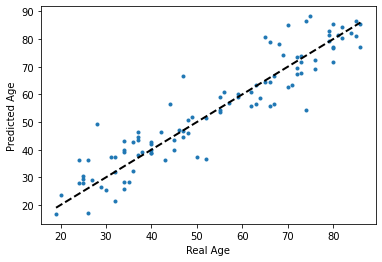

In [9]:
import matplotlib.pyplot as plt
out_dir = './output'
model_dir = os.path.join(out_dir, 'model')
model = ResNet3D(BasicBlock, [1, 1, 1, 1], [res_d, res_d * 2, res_d * 4, res_d * 8], 1).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_cnn.pt')))
model.eval()

meta_data = pd.read_csv(data_dir + f'meta/meta_data_regression_test.csv')
ids, ages = list(meta_data['subject_id']), list(meta_data["age"])
files_n_ages = []
for f, age in zip(ids, ages):
    img_path = data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz'
    msk_path = data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz'
    files_n_ages.append((img_path, msk_path, float(age)))
test_dataset = ImageRegressionDataset(files_n_ages, img_spacing, img_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

sum_samples, sum_l1 = 0, 0
all_preds, all_ages = [], []
for batch_idx, batch_samples in enumerate(test_dataloader):
    img, age = batch_samples['img'].to(device), batch_samples['age'].to(device).float()
    with torch.no_grad():
        prd = model(img)
    sum_l1 += torch.sum(torch.abs(prd - age)).item()
    sum_samples += img.size(0)
    all_preds.append(prd.cpu().numpy())
    all_ages.append(age.cpu().numpy())

test_l1 = sum_l1 / sum_samples
all_preds, all_ages = np.concatenate(all_preds), np.concatenate(all_ages)
print("Average testing MAE: ", test_l1)

fig, ax = plt.subplots()
ax.scatter(all_ages, all_preds, marker='.')
ax.plot([all_ages.min(), all_ages.max()], [all_ages.min(), all_ages.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

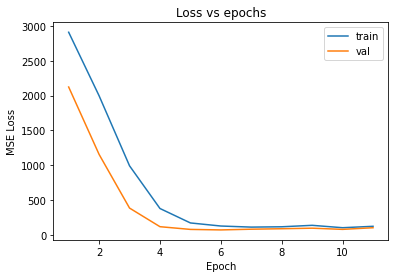

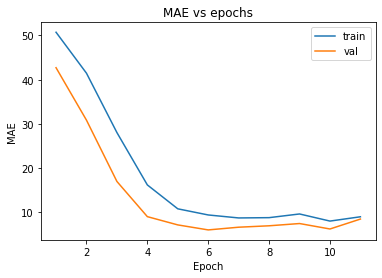

In [11]:
plt.plot(list(range(1, len(loss_logs["train"]) + 1)), loss_logs["train"], label = "train")
plt.plot(list(range(1, len(loss_logs["val"]) + 1)), loss_logs["val"], label = "val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss vs epochs")
plt.show()

plt.plot(list(range(1, len(l1_logs["train"]) + 1)), l1_logs["train"], label = "train")
plt.plot(list(range(1, len(l1_logs["val"]) + 1)), l1_logs["val"], label = "val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE vs epochs")
plt.show()


In [18]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 227401
